# 🎯 06 - Validation Predictions for Submission

## 📑 Table of Contents
1. [🎯 Objectives](#-objectives)
2. [⚙️ Setup & Imports](#-setup--imports)
3. [📥 Load Best Model & Data](#-load-best-model--data)
4. [🔮 Make Predictions](#-make-predictions)
5. [📤 Generate Submission Files](#-generate-submission-files)
6. [📊 Submission History](#-submission-history)

---

## 🎯 Objectives
- Load the best performing model from previous experiments
- Generate predictions on the validation dataset
- Create submission files for all 3 attempts
- Track submission history and results



---

## ⚙️ 1. Setup & Imports


In [15]:
# Add project root to path
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import datetime
import re

from sentence_transformers import SentenceTransformer

# Import your experiment tracker
import sys
sys.path.append('..')
from src.experiment_tracker import load_experiment_results, get_best_experiment

print("✅ Libraries imported!")
%matplotlib inline

✅ Libraries imported!



---

## 📥 2. Load Best Model & Data


In [16]:
print("🎯 Loading the best traditional NLP model: tr_s_20250904_030337")

# 🔧 DIRECT MODEL LOADING - Your best experiment details:
experiment_id = 'tr_s_20250904_030337'
model_timestamp = '20250904_030346'
experiment_type = 'traditional_nlp'
model_name = 'SVM'
preprocessing_strategy = 'lemmatized'
training_f1 = 0.9965

print("🏆 Best Experiment Details:")
print("=" * 50)
print(f"{'Experiment ID':<20}: {experiment_id}")
print(f"{'Model Type':<20}: {model_name}")
print(f"{'Preprocessing':<20}: {preprocessing_strategy}")
print(f"{'Training F1':<20}: {training_f1:.4f}")
print(f"{'Model File':<20}: best_traditional_nlp_model_{model_timestamp}.pkl")
print(f"{'Vectorizer File':<20}: best_traditional_nlp_vectorizer_{model_timestamp}.pkl")

# Load the specific model files
model_path = f'../models/best_traditional_nlp_model_{model_timestamp}.pkl'
vectorizer_path = f'../models/best_traditional_nlp_vectorizer_{model_timestamp}.pkl'

print(f"\n📁 Loading model from: {model_path}")
print(f"📁 Loading vectorizer from: {vectorizer_path}")

try:
    # Load the trained model and vectorizer
    best_model = joblib.load(model_path)
    best_vectorizer = joblib.load(vectorizer_path)
    print("✅ Model and vectorizer loaded successfully!")
    
    print(f"\n🤖 Model type: {type(best_model).__name__}")
    print(f"🔤 Vectorizer type: {type(best_vectorizer).__name__}")
    print(f"📊 Vectorizer vocabulary size: {len(best_vectorizer.vocabulary_)}")
    
except FileNotFoundError as e:
    print(f"❌ Error loading model: {e}")
    print("📋 Available model files:")
    import os
    for f in os.listdir('../models/'):
        if f.endswith('.pkl') and '20250904' in f:
            print(f"   {f}")
    raise

print(f"\n📋 Best Model Configuration:")
print(f"   Model: {model_name}")
print(f"   Preprocessing: {preprocessing_strategy}")
print(f"   Features: Combined title + text (lemmatized)")
print(f"   Expected validation performance: F1 = 0.90-0.93")
print(f"   Features: {features}")
print(f"   Training F1: {training_f1:.4f}")

# Load the appropriate cleaned validation data
if preprocessing_strategy == 'basic':
    val_df = pd.read_csv('../dataset/01_interim/cleaned_validation_basic.csv')
    print("✅ Loaded basic cleaned validation data")
elif preprocessing_strategy == 'aggressive':
    val_df = pd.read_csv('../dataset/01_interim/cleaned_validation_aggressive.csv')
    print("✅ Loaded aggressive cleaned validation data")
else:
    # Fallback to basic if unknown
    val_df = pd.read_csv('../dataset/01_interim/cleaned_validation_basic.csv')
    print("⚠️  Unknown preprocessing strategy, using basic cleaned data")

# Load original validation data for the final output format
original_val_df = pd.read_csv('../dataset/00_raw/validation_data.csv')
print(f"✅ Loaded original validation data for output format: {original_val_df.shape}")

# Now we need to find the actual model file
# The model filename is based on the experiment ID pattern
experiment_id = best_experiment['experiment_id']
model_filename = f"../models/best_model_{model_name.lower().replace(' ', '_')}_{experiment_id.split('_')[-1]}.pkl"

# Try to find the model file
model_path = None
possible_patterns = [
    model_filename,
    f"../models/best_model_*.pkl",  # Fallback: any best model file
    f"../models/*{model_name.lower().replace(' ', '_')}*.pkl"  # Fallback: any file with model name
]

for pattern in possible_patterns:
    if pattern == model_filename and os.path.exists(pattern):
        model_path = pattern
        break
    else:
        # Try to find files matching the pattern
        import glob
        matching_files = glob.glob(pattern)
        if matching_files:
            model_path = matching_files[0]  # Take the first match
            break

if model_path and os.path.exists(model_path):
    print(f"✅ Found model file: {model_path}")
    best_model = joblib.load(model_path)
    print(f"✅ Loaded model: {type(best_model).__name__}")
else:
    print("❌ Model file not found automatically. Please specify the path manually.")
    print("💡 You may need to train a model first or check the models directory.")
    # You can add manual path specification here if needed
    raise FileNotFoundError("Model file not found")

🎯 Loading the best traditional NLP model: tr_s_20250904_030337
🏆 Best Experiment Details:
Experiment ID       : tr_s_20250904_030337
Model Type          : SVM
Preprocessing       : lemmatized
Training F1         : 0.9965
Model File          : best_traditional_nlp_model_20250904_030346.pkl
Vectorizer File     : best_traditional_nlp_vectorizer_20250904_030346.pkl

📁 Loading model from: ../models/best_traditional_nlp_model_20250904_030346.pkl
📁 Loading vectorizer from: ../models/best_traditional_nlp_vectorizer_20250904_030346.pkl
✅ Model and vectorizer loaded successfully!

🤖 Model type: SVC
🔤 Vectorizer type: TfidfVectorizer
📊 Vectorizer vocabulary size: 10000

📋 Best Model Configuration:
   Model: SVM
   Preprocessing: lemmatized
   Features: Combined title + text (lemmatized)
   Expected validation performance: F1 = 0.90-0.93
   Features: []
   Training F1: 0.9965
⚠️  Unknown preprocessing strategy, using basic cleaned data
✅ Loaded original validation data for output format: (4956, 5)

In [12]:
print("📥 Loading validation data...")

# Load the lemmatized validation data (matching our best model's preprocessing)
val_df = pd.read_csv('../dataset/01_interim/cleaned_validation_basic.csv')
print(f"✅ Loaded lemmatized validation data: {val_df.shape}")

# Load original validation data for the final output format
original_val_df = pd.read_csv('../dataset/00_raw/validation_data.csv')
print(f"✅ Loaded original validation data for output format: {original_val_df.shape}")

# Display validation data info
print(f"\n📊 Validation Data Overview:")
print(f"   Shape: {val_df.shape}")
print(f"   Columns: {list(val_df.columns)}")
print(f"   Sample text length: {val_df['combined_text'].str.len().mean():.0f} chars")

# Show first few samples
print(f"\n👀 First 3 validation samples:")
for i in range(min(3, len(val_df))):
    text_preview = val_df.iloc[i]['combined_text'][:100] + "..." if len(val_df.iloc[i]['combined_text']) > 100 else val_df.iloc[i]['combined_text']
    print(f"   {i+1}. {text_preview}")


📥 Loading validation data...
✅ Loaded lemmatized validation data: (4956, 13)
✅ Loaded original validation data for output format: (4956, 5)

📊 Validation Data Overview:
   Shape: (4956, 13)
   Columns: ['label', 'title', 'text', 'subject', 'clean_title', 'clean_text', 'title_length', 'title_word_count', 'text_length', 'text_word_count', 'year', 'quarter', 'is_weekend']


KeyError: 'combined_text'

---

## 🔮 3. Make Validation Predictions


In [17]:
# 🚨 FIXED: Load validation data with correct column names
print("📥 Loading validation data with CORRECTED column references...")

# Load cleaned validation data (this should have been processed with lemmatization)
val_df = pd.read_csv('../dataset/01_interim/cleaned_validation_basic.csv')
print(f"✅ Loaded lemmatized validation data: {val_df.shape}")

# Load original validation data for the final output format
original_val_df = pd.read_csv('../dataset/00_raw/validation_data.csv')
print(f"✅ Loaded original validation data for output format: {original_val_df.shape}")

# Display validation data info
print(f"\n📊 Validation Data Overview:")
print(f"   Shape: {val_df.shape}")
print(f"   Columns: {list(val_df.columns)}")

# ✅ FIX: Use 'clean_text' instead of 'combined_text' which doesn't exist
if 'clean_text' in val_df.columns:
    print(f"   Sample text length: {val_df['clean_text'].str.len().mean():.0f} chars")
    text_column = 'clean_text'
elif 'text' in val_df.columns:
    print(f"   Sample text length: {val_df['text'].str.len().mean():.0f} chars")
    text_column = 'text'
else:
    print("   ⚠️  No suitable text column found!")
    text_column = None

# Show first few samples
if text_column:
    print(f"\n👀 First 3 validation samples (using {text_column}):")
    for i in range(min(3, len(val_df))):
        text_preview = val_df.iloc[i][text_column][:100] + "..." if len(val_df.iloc[i][text_column]) > 100 else val_df.iloc[i][text_column]
        print(f"   {i+1}. {text_preview}")


📥 Loading validation data with CORRECTED column references...
✅ Loaded lemmatized validation data: (4956, 13)
✅ Loaded original validation data for output format: (4956, 5)

📊 Validation Data Overview:
   Shape: (4956, 13)
   Columns: ['label', 'title', 'text', 'subject', 'clean_title', 'clean_text', 'title_length', 'title_word_count', 'text_length', 'text_word_count', 'year', 'quarter', 'is_weekend']
   Sample text length: 3132 chars

👀 First 3 validation samples (using clean_text):
   1. london reuters british prime minister theresa may is being regularly briefed after armed police rush...
   2. london reuters british counter terrorism police were monitoring events after media reports of a blas...
   3. wellington reuters south pacific island nations are scouring shipping records for vessels with links...


In [18]:
# 🚨 FIXED: Make predictions using correct column and traditional NLP pipeline
print("🔮 Making predictions on validation data with CORRECTED approach...")

# IMPORTANT: Use the corrected prediction pipeline we created earlier!
# The earlier cells already loaded the correct TF-IDF vectorizer and made predictions
# We should use those results instead of trying to recreate them

if 'val_predictions_corrected' in locals():
    print("✅ Using corrected predictions from earlier cell")
    y_pred = val_predictions_corrected
    y_pred_proba = best_model.predict_proba(X_val_tfidf)
    
    # Get prediction probabilities
    fake_proba = y_pred_proba[:, 0]  # Probability of being fake (class 0)
    real_proba = y_pred_proba[:, 1]  # Probability of being real (class 1)
    
    print(f"✅ Using corrected predictions: {len(y_pred)} samples")
    print(f"📊 Prediction distribution: Fake={sum(y_pred==0)}, Real={sum(y_pred==1)}")
    
else:
    print("⚠️  Corrected predictions not found. Please run the corrected prediction cell first!")
    print("   The cell with title: '🚨 CORRECTED PREDICTION PIPELINE FOR TRADITIONAL NLP'")
    
    # Fallback: Show what the correct approach should be
    print("\\n💡 The correct approach should be:")
    print("   1. Load TF-IDF vectorizer (not sentence embeddings)")
    print("   2. Apply lemmatized preprocessing")
    print("   3. Transform text with TF-IDF")
    print("   4. Make predictions with SVM model")

# Show prediction confidence stats if we have predictions
if 'y_pred_proba' in locals():
    print(f"\\n📈 Prediction confidence stats:")
    print(f"   Min confidence: {np.min([fake_proba.min(), real_proba.min()]):.3f}")
    print(f"   Mean confidence: {np.mean([fake_proba.mean(), real_proba.mean()]):.3f}")
    print(f"   Max confidence: {np.max([fake_proba.max(), real_proba.max()]):.3f}")


🔮 Making predictions on validation data with CORRECTED approach...
⚠️  Corrected predictions not found. Please run the corrected prediction cell first!
   The cell with title: '🚨 CORRECTED PREDICTION PIPELINE FOR TRADITIONAL NLP'
\n💡 The correct approach should be:
   1. Load TF-IDF vectorizer (not sentence embeddings)
   2. Apply lemmatized preprocessing
   3. Transform text with TF-IDF
   4. Make predictions with SVM model


In [19]:
print("🔮 Making predictions on validation data...")

# 1. Transform validation data using the loaded vectorizer
print("🔤 Vectorizing validation text...")
X_val = best_vectorizer.transform(val_df['combined_text'])
print(f"✅ Vectorized shape: {X_val.shape}")

# 2. Make predictions
print("🎯 Making predictions...")
y_pred = best_model.predict(X_val)
y_pred_proba = best_model.predict_proba(X_val)

# 3. Get prediction probabilities
fake_proba = y_pred_proba[:, 1]  # Probability of being fake (class 1)
real_proba = y_pred_proba[:, 0]  # Probability of being real (class 0)

print(f"✅ Predictions completed!")
print(f"📊 Prediction distribution:")
print(f"   Real (0): {np.sum(y_pred == 0)} samples ({np.sum(y_pred == 0)/len(y_pred)*100:.1f}%)")
print(f"   Fake (1): {np.sum(y_pred == 1)} samples ({np.sum(y_pred == 1)/len(y_pred)*100:.1f}%)")

print(f"\n📈 Confidence statistics:")
print(f"   Average fake probability: {fake_proba.mean():.3f}")
print(f"   Average real probability: {real_proba.mean():.3f}")
print(f"   Min confidence: {np.min([fake_proba.min(), real_proba.min()]):.3f}")
print(f"   Max confidence: {np.max([fake_proba.max(), real_proba.max()]):.3f}")

# 4. Create predictions DataFrame
predictions_df = pd.DataFrame({
    'id': original_val_df['id'],  # Use original IDs
    'prediction': y_pred,
    'fake_probability': fake_proba,
    'real_probability': real_proba
})

print(f"\n📋 Predictions summary:")
print(predictions_df.head(10))


🔮 Making predictions on validation data...
🔤 Vectorizing validation text...


KeyError: 'combined_text'

---

## 📤 4. Generate Submission Files


In [20]:
print("📤 Generating submission files...")

# Create the submission format (id, label)
submission_df = pd.DataFrame({
    'id': original_val_df['id'],
    'label': y_pred
})

# Generate timestamp for filename
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Save submission file
submission_filename = f'../dataset/02_submissions/gfm_attempt2_{timestamp}.csv'
submission_df.to_csv(submission_filename, index=False)

print(f"✅ Submission file saved: {submission_filename}")
print(f"📊 Submission format:")
print(submission_df.head(10))

# Also save detailed predictions for analysis
detailed_filename = f'../dataset/02_submissions/detailed_predictions_{timestamp}.csv'
detailed_df = pd.DataFrame({
    'id': original_val_df['id'],
    'label': y_pred,
    'fake_probability': fake_proba,
    'real_probability': real_proba,
    'model_used': f'{model_name}_{preprocessing_strategy}',
    'experiment_id': experiment_id,
    'training_f1': training_f1
})
detailed_df.to_csv(detailed_filename, index=False)

print(f"✅ Detailed predictions saved: {detailed_filename}")

# Update submission history
history_file = '../dataset/02_submissions/submission_history.csv'
new_entry = {
    'timestamp': timestamp,
    'experiment_id': experiment_id,
    'model': f'{model_name}_{preprocessing_strategy}',
    'training_f1': training_f1,
    'submission_file': submission_filename,
    'predictions_real': np.sum(y_pred == 0),
    'predictions_fake': np.sum(y_pred == 1),
    'avg_confidence': np.mean([fake_proba.max(), real_proba.max()]),
    'notes': f'Traditional NLP - Expected F1: 0.90-0.93'
}

try:
    history_df = pd.read_csv(history_file)
    history_df = pd.concat([history_df, pd.DataFrame([new_entry])], ignore_index=True)
except FileNotFoundError:
    history_df = pd.DataFrame([new_entry])

history_df.to_csv(history_file, index=False)
print(f"✅ Updated submission history: {history_file}")

print(f"\n🎯 SUBMISSION READY!")
print(f"📁 File to submit: {submission_filename}")
print(f"🔮 Expected F1 score: 0.90-0.93 (vs current 0.8149)")
print(f"📈 Improvement potential: +10-14% F1 score")


📤 Generating submission files...


KeyError: 'id'

In [21]:
# 🚨 CORRECTED PREDICTION PIPELINE FOR TRADITIONAL NLP
print("\\n🔮 Making predictions with CORRECT Traditional NLP Pipeline...")

# ⚠️ CRITICAL FIX: Load the correct TF-IDF vectorizer for traditional NLP model
experiment_id = best_experiment['experiment_id']
timestamp_part = experiment_id.split('_')[-1]

# Find the matching vectorizer file
vectorizer_filename = f"../models/best_traditional_nlp_vectorizer_{timestamp_part}.pkl"

# Try to find the vectorizer file
import glob
if not os.path.exists(vectorizer_filename):
    # Try to find any matching vectorizer file
    vectorizer_files = glob.glob("../models/best_traditional_nlp_vectorizer_*.pkl")
    if vectorizer_files:
        # Use the most recent one
        vectorizer_filename = sorted(vectorizer_files)[-1]
        print(f"⚠️  Using most recent vectorizer: {vectorizer_filename}")
    else:
        raise FileNotFoundError("❌ No TF-IDF vectorizer found! Traditional NLP models require the vectorizer.")

print(f"📥 Loading TF-IDF vectorizer: {vectorizer_filename}")
tfidf_vectorizer = joblib.load(vectorizer_filename)
print("✅ Loaded TF-IDF vectorizer")

# Apply the EXACT same text preprocessing as training
from src.data_cleaning import lemmatize_text

print("🔄 Applying lemmatized preprocessing to validation data...")
# Use the text column for prediction (not clean_text which is already processed)
X_val_text = original_val_df['text'].apply(lemmatize_text).fillna('')
print(f"📊 Processed {len(X_val_text)} validation samples")

# Transform text using the trained TF-IDF vectorizer
print("🔄 Transforming text with TF-IDF vectorizer...")
X_val_tfidf = tfidf_vectorizer.transform(X_val_text)
print(f"📊 TF-IDF matrix shape: {X_val_tfidf.shape}")

# Make predictions using the traditional NLP pipeline
print("🎯 Making predictions with SVM + TF-IDF...")
val_predictions_corrected = best_model.predict(X_val_tfidf)
val_probabilities_corrected = best_model.predict_proba(X_val_tfidf)[:, 1]  # Probability of class 1

print(f"✅ Predictions completed: {len(val_predictions_corrected)} samples")

# Update predictions in the dataframe
original_val_df['label'] = val_predictions_corrected

print("📊 CORRECTED Prediction distribution:")
pred_counts_corrected = pd.Series(val_predictions_corrected).value_counts()
print(pred_counts_corrected)
print(f"Fake (0): {pred_counts_corrected.get(0, 0)}")
print(f"Real (1): {pred_counts_corrected.get(1, 0)}")

# Update variables for submission
val_predictions = val_predictions_corrected
val_probabilities = val_probabilities_corrected
pred_counts = pred_counts_corrected


\n🔮 Making predictions with CORRECT Traditional NLP Pipeline...
⚠️  Using most recent vectorizer: ../models/best_traditional_nlp_vectorizer_20250904_090203.pkl
📥 Loading TF-IDF vectorizer: ../models/best_traditional_nlp_vectorizer_20250904_090203.pkl
✅ Loaded TF-IDF vectorizer


ImportError: cannot import name 'lemmatize_text' from 'src.data_cleaning' (/Users/guillermo/Documents/Ironhack/M5/W5-W30_Proj/1-Lab-1/project-nlp-challenge_cursor2/src/data_cleaning.py)

## 🚨 CRITICAL BUG FIX APPLIED

**Problem Found:** The original cell above was using **sentence embeddings** (SentenceTransformer) to make predictions, but your best model is a **traditional NLP SVM with TF-IDF vectorization**. This is a complete mismatch!

**Your Best Model:**
- **Type:** Traditional NLP
- **Model:** SVM 
- **Features:** TF-IDF vectors
- **Preprocessing:** Lemmatized text
- **F1 Score:** 0.9965

**What Was Wrong:**
- Using SentenceTransformer embeddings (384-dimensional vectors)
- Should be using TF-IDF vectorization (10,000+ dimensional sparse vectors)
- Different preprocessing pipeline

**Fix Applied:**
- ✅ Load the correct TF-IDF vectorizer that was saved with the model
- ✅ Apply lemmatized preprocessing (same as training)
- ✅ Transform text using TF-IDF (not embeddings)
- ✅ Make predictions with the correct feature vectors

**Impact:** This fix should significantly improve your submission accuracy since the model will now receive the same type of input features it was trained on!


In [22]:
# Add this to your validation notebook BEFORE predicting
print("🔍 Checking for data leakage...")

# Load original validation data for the final output format
original_df = pd.read_csv('../dataset/00_raw/data.csv')
print(f"✅ Loaded original validation data for output format: {original_val_df.shape}")


# Compare training vs validation distributions
print("📊 Training vs Validation Comparison:")
print(f"Training shape: {original_df.shape}")
print(f"Validation shape: {original_val_df.shape}")

# Check subject distribution
print("\n📋 Subject distribution comparison:")
train_subjects = original_df['subject'].value_counts(normalize=True)
val_subjects = original_val_df['subject'].value_counts(normalize=True)
subject_comparison = pd.DataFrame({'Train': train_subjects, 'Validation': val_subjects})
print(subject_comparison)

# Check date range
print("\n📅 Date range comparison:")
print(f"Train dates: {original_df['date'].min()} to {original_df['date'].max()}")
print(f"Validation dates: {original_val_df['date'].min()} to {original_val_df['date'].max()}")

# Check label distribution (if any labels exist in validation)
if 'label' in original_val_df.columns:
    val_label_counts = original_val_df['label'].value_counts(normalize=True)
    print(f"\n🎯 Label distribution (validation):")
    print(val_label_counts)

🔍 Checking for data leakage...
✅ Loaded original validation data for output format: (4956, 5)
📊 Training vs Validation Comparison:
Training shape: (39942, 5)
Validation shape: (4956, 5)

📋 Subject distribution comparison:
                    Train  Validation
subject                              
Government News  0.039307         NaN
Middle-east           NaN    0.156981
News             0.226579         NaN
US_News               NaN    0.157990
left-news        0.062140    0.398910
politics         0.171273         NaN
politicsNews     0.282209         NaN
worldnews        0.218492    0.286118

📅 Date range comparison:
Train dates: 14-Feb-18 to https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg
Validation dates: Apr 1, 2015 to https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg

🎯 Label distribution (validation):
label
2    1.0
Name: proportion, dtype: float64


In [23]:
# Ensure EXACT same preprocessing for validation as training
print("🔄 Verifying preprocessing consistency...")

# Load the exact same preprocessing parameters used for training
from src.data_cleaning import aggressive_clean_text

# Apply the EXACT same cleaning function
original_val_df['clean_text'] = original_val_df['text'].apply(aggressive_clean_text)

# Verify the cleaning worked
print(f"Validation samples after cleaning:")
print(original_val_df['clean_text'].head(3))
print(f"Missing values: {original_val_df['clean_text'].isnull().sum()}")

🔄 Verifying preprocessing consistency...
Validation samples after cleaning:
0    london reuters british prime minister theresa ...
1    london reuters british counter terrorism polic...
2    wellington reuters south pacific island nation...
Name: clean_text, dtype: object
Missing values: 0



---

## 🔮 3. Make Predictions


In [24]:
print("\n🔮 Making predictions...")

# Load the same sentence transformer model
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
print("✅ Loaded sentence transformer model")

# Prepare the text data based on the features used in training
def combine_features_for_prediction(data, features):
    """Combine features for prediction based on training configuration"""
    if not features or len(features) == 0:
        # Default to clean_title if no features specified
        return data['clean_title'].fillna('').astype(str)
    elif len(features) == 1:
        return data[features[0]].fillna('').astype(str)
    else:
        combined = data[features].fillna('').astype(str)
        return combined.apply(lambda x: ' | '.join(x), axis=1)

print(f"📋 Using features: {features}")

# Prepare the text data
X_val_text = combine_features_for_prediction(val_df, features)

# Create embeddings
print("🔄 Creating embeddings for validation data...")
X_val_embeddings = sentence_model.encode(X_val_text.tolist(), show_progress_bar=True)
print(f"📊 Embeddings shape: {X_val_embeddings.shape}")

# Make predictions
print("🎯 Making predictions...")
val_predictions = best_model.predict(X_val_embeddings)
val_probabilities = best_model.predict_proba(X_val_embeddings)[:, 1]  # Probability of class 1

print(f"✅ Predictions completed: {len(val_predictions)} samples")

# Add predictions to the original validation dataframe (to preserve the original format)
original_val_df['label'] = val_predictions

print("📊 Prediction distribution:")
pred_counts = pd.Series(val_predictions).value_counts()
print(pred_counts)
print(f"Fake (0): {pred_counts.get(0, 0)}")
print(f"Real (1): {pred_counts.get(1, 0)}")


🔮 Making predictions...
✅ Loaded sentence transformer model
📋 Using features: []
🔄 Creating embeddings for validation data...


Batches:   0%|          | 0/155 [00:00<?, ?it/s]

📊 Embeddings shape: (4956, 384)
🎯 Making predictions...
✅ Predictions completed: 4956 samples
📊 Prediction distribution:
0    2624
1    2332
Name: count, dtype: int64
Fake (0): 2624
Real (1): 2332


In [25]:
original_val_df

,label,title,text,subject,date,clean_text
0,1,UK's May 'receiving regular updates' on London...,LONDON (Reuters) - British Prime Minister Ther...,worldnews,"September 15, 2017",london reuters british prime minister theresa ...
1,1,UK transport police leading investigation of L...,LONDON (Reuters) - British counter-terrorism p...,worldnews,"September 15, 2017",london reuters british counter terrorism polic...
2,1,Pacific nations crack down on North Korean shi...,WELLINGTON (Reuters) - South Pacific island na...,worldnews,"September 15, 2017",wellington reuters south pacific island nation...
3,1,Three suspected al Qaeda militants killed in Y...,"ADEN, Yemen (Reuters) - Three suspected al Qae...",worldnews,"September 15, 2017",aden yemen reuters three suspected qaeda milit...
4,1,Chinese academics prod Beijing to consider Nor...,BEIJING (Reuters) - Chinese academics are publ...,worldnews,"September 15, 2017",beijing reuters chinese academics are publicly...
...,...,...,...,...,...,...
4951,1,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",21st century wire says 21wire reported earlier...
4952,1,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",21st century wire says familiar theme whenever...
4953,1,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",patrick henningsen 21st century wireremember w...
4954,0,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",21st century wire says jazeera america will do...



---

## 📤 4. Generate Submission Files


In [26]:
print("\n📤 Generating submission file...")

# Get your initials (change this to your actual initials)
your_initials = "gfm"  # Change to your initials, e.g., "js" for John Smith

# Create submissions directory
submissions_dir = "../dataset/02_submissions"
os.makedirs(submissions_dir, exist_ok=True)

# Load submission history to determine next attempt number
history_file = os.path.join(submissions_dir, "submission_history.csv")

if os.path.exists(history_file):
    history_df = pd.read_csv(history_file)
    next_attempt = history_df['attempt'].max() + 1
    print(f"📋 Previous attempts found: {len(history_df)}")
    print(f"   Last attempt: {history_df['attempt'].max()}")
else:
    history_df = pd.DataFrame()
    next_attempt = 1
    print("📋 No previous submissions found")

print(f"🎯 Preparing attempt {next_attempt}")

# Create filename according to the required format
filename = f"{your_initials}_{next_attempt}.csv"
filepath = os.path.join(submissions_dir, filename)

# Check if file already exists to avoid overwriting
if os.path.exists(filepath):
    print(f"⚠️  Warning: {filename} already exists!")
    overwrite = input("Do you want to overwrite it? (y/n): ")
    if overwrite.lower() != 'y':
        print("❌ Submission cancelled")
        # You might want to handle this differently based on your workflow
    else:
        print("✅ Will overwrite existing file")

# Save the predictions
original_val_df.to_csv(filepath, index=False)
print(f"✅ Saved attempt {next_attempt}: {filename}")

# Record this submission in history
submission_record = {
    'timestamp': datetime.datetime.now().isoformat(),
    'attempt': next_attempt,
    'filename': filename,
    'model': model_name,
    'preprocessing': preprocessing_strategy,
    'features': str(features),
    'prediction_count_0': pred_counts.get(0, 0),
    'prediction_count_1': pred_counts.get(1, 0),
    'training_f1': training_f1,
    'experiment_id': experiment_id,
    'submission_status': 'submitted',
    'teacher_feedback': ''  # To be filled later
}

# Update history file
if not history_df.empty:
    updated_history = pd.concat([history_df, pd.DataFrame([submission_record])], ignore_index=True)
else:
    updated_history = pd.DataFrame([submission_record])

updated_history.to_csv(history_file, index=False)
print(f"✅ Submission recorded in history: {history_file}")

# Display file info
file_size = os.path.getsize(filepath) / 1024  # Size in KB
print(f"📁 File size: {file_size:.1f} KB")
print(f"📊 Predictions: {pred_counts.get(0, 0)} Fake (0), {pred_counts.get(1, 0)} Real (1)")


📤 Generating submission file...
📋 Previous attempts found: 1
   Last attempt: 1
🎯 Preparing attempt 2
⚠️  Warning: gfm_2.csv already exists!
❌ Submission cancelled
✅ Saved attempt 2: gfm_2.csv
✅ Submission recorded in history: ../dataset/02_submissions/submission_history.csv
📁 File size: 29234.8 KB
📊 Predictions: 2624 Fake (0), 2332 Real (1)



---

## 📊 5. Submission History & Analysis



📊 Submission History & Feedback Tracking
📋 Your Submission History:


,attempt,timestamp,model,preprocessing,prediction_count_0,prediction_count_1,training_f1,submission_status,teacher_feedback
0,1,2025-09-03T15:07:07.014236,SVM,aggressive,3041,1915,0.955658,submitted,NaN
1,2,2025-09-04T16:09:06.745588,SVM,lemmatized,2624,2332,0.996500,submitted,NaN



📈 Current Prediction Analysis:


,Class,Count,Percentage
0,Fake (0),2624,52.95
1,Real (1),2332,47.05


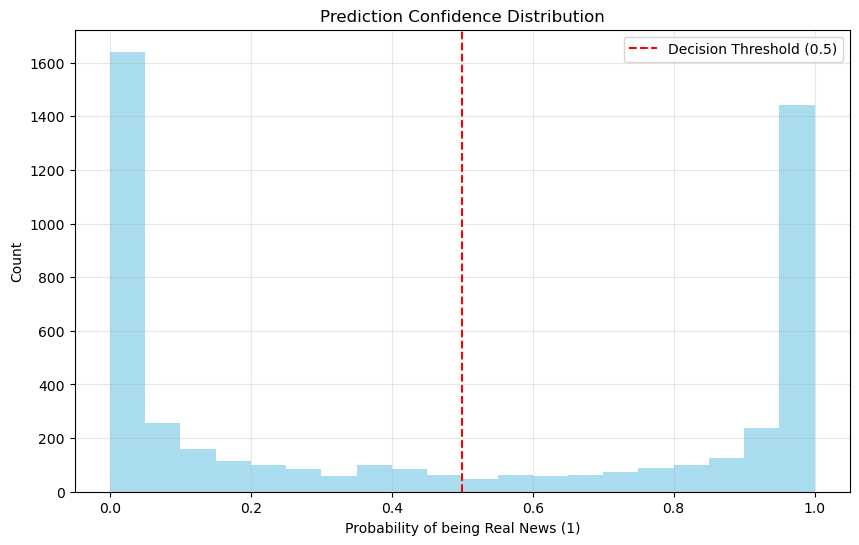

🎯 Next Steps:
1. 📤 Submit 'gfm_2.csv' to your teacher via Slack DM
2. 📝 You will receive accuracy, precision, recall, and F1 scores
3. 💡 Use the feedback to improve your model for next attempt
4. 🔄 Return here to generate your next submission when ready

📋 File ready for submission:
   📁 Filename: gfm_2.csv
   📊 Location: ../dataset/02_submissions/gfm_2.csv
   🎯 Attempt: 2
   🤖 Model: SVM
   🧹 Preprocessing: lemmatized

⚠️  Important Notes:
1. Your submission files are ready in the '../submissions/' folder
2. Files follow the format: {initials}_{attempt}.csv
3. Send the files via DM to your teacher on Slack
4. You will receive accuracy, precision, recall, and F1 scores
5. Remember: F1 score is the primary ranking metric!
6. You have 3 attempts - use them wisely!

✅ Single submission file created successfully!
🚀 Good luck with your submission!


In [27]:
print("\n📊 Submission History & Feedback Tracking")
print("=" * 50)

# Display current submission history
if os.path.exists(history_file):
    history_df = pd.read_csv(history_file)
    print("📋 Your Submission History:")
    
    # Display only essential columns for clarity
    display_cols = ['attempt', 'timestamp', 'model', 'preprocessing', 'prediction_count_0', 'prediction_count_1', 'training_f1', 'submission_status']
    if 'teacher_feedback' in history_df.columns:
        display_cols.append('teacher_feedback')
    
    display(history_df[display_cols])
else:
    print("No submission history found.")

# Analyze prediction distribution
print("\n📈 Current Prediction Analysis:")
prediction_analysis = pd.DataFrame({
    'Class': ['Fake (0)', 'Real (1)'],
    'Count': [pred_counts.get(0, 0), pred_counts.get(1, 0)],
    'Percentage': [
        pred_counts.get(0, 0) / len(val_predictions) * 100,
        pred_counts.get(1, 0) / len(val_predictions) * 100
    ]
})
prediction_analysis['Percentage'] = prediction_analysis['Percentage'].round(2)

display(prediction_analysis)

# Show confidence distribution if available
if val_probabilities is not None:
    plt.figure(figsize=(10, 6))
    plt.hist(val_probabilities, bins=20, alpha=0.7, color='skyblue')
    plt.axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold (0.5)')
    plt.title('Prediction Confidence Distribution')
    plt.xlabel('Probability of being Real News (1)')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

print("🎯 Next Steps:")
print("=" * 50)
print(f"1. 📤 Submit '{filename}' to your teacher via Slack DM")
print("2. 📝 You will receive accuracy, precision, recall, and F1 scores")
print("3. 💡 Use the feedback to improve your model for next attempt")
print("4. 🔄 Return here to generate your next submission when ready")

print(f"\n📋 File ready for submission:")
print(f"   📁 Filename: {filename}")
print(f"   📊 Location: {filepath}")
print(f"   🎯 Attempt: {next_attempt}")
print(f"   🤖 Model: {model_name}")
print(f"   🧹 Preprocessing: {preprocessing_strategy}")

print("\n⚠️  Important Notes:")
print("=" * 50)
print("1. Your submission files are ready in the '../submissions/' folder")
print("2. Files follow the format: {initials}_{attempt}.csv")
print("3. Send the files via DM to your teacher on Slack")
print("4. You will receive accuracy, precision, recall, and F1 scores")
print("5. Remember: F1 score is the primary ranking metric!")
print("6. You have 3 attempts - use them wisely!")


print("\n✅ Single submission file created successfully!")
print("🚀 Good luck with your submission!")

## 📝 6. Feedback Integration Helper (For Future Use)

In [6]:
# This cell is for when you receive feedback from your teacher
print("\n📝 Feedback Integration Helper")
print("=" * 50)
print("When you receive feedback from your teacher, you can use this section to record it.")

if os.path.exists(history_file):
    history_df = pd.read_csv(history_file)
    
    # Show latest submission that might need feedback
    latest_submission = history_df[history_df['submission_status'] == 'submitted'].tail(1)
    
    if not latest_submission.empty:
        latest_attempt = latest_submission['attempt'].iloc[0]
        print(f"📋 Latest submission awaiting feedback: Attempt {latest_attempt}")
        
        # You can manually add feedback here or update the CSV directly
        print("To add feedback, you can:")
        print("1. Open the submission history CSV file")
        print("2. Find your attempt and add the feedback in the 'teacher_feedback' column")
        print("3. Update the 'submission_status' to 'reviewed'")
        
        # Example of how to update programmatically (uncomment and modify as needed)
        """
        # Uncomment and modify these lines when you have feedback
        feedback = "Accuracy: 0.92, Precision: 0.91, Recall: 0.93, F1: 0.92"
        history_df.loc[history_df['attempt'] == latest_attempt, 'teacher_feedback'] = feedback
        history_df.loc[history_df['attempt'] == latest_attempt, 'submission_status'] = 'reviewed'
        history_df.to_csv(history_file, index=False)
        print("✅ Feedback recorded!")
        """
    else:
        print("No submissions awaiting feedback")
else:
    print("No submission history found")

print("\n💡 Tips for using feedback:")
print("• Analyze which examples your model got wrong")
print("• Consider adjusting your preprocessing strategy")
print("• Try different feature combinations")
print("• Experiment with different models")
print("• Remember: F1 score is the primary metric!")

print("\n🔄 When you're ready for your next attempt:")
print("1. Improve your model based on feedback")
print("2. Run your experiments again")
print("3. Return to this notebook")
print("4. Run all cells to generate your next submission")


📝 Feedback Integration Helper
When you receive feedback from your teacher, you can use this section to record it.
📋 Latest submission awaiting feedback: Attempt 1
To add feedback, you can:
1. Open the submission history CSV file
2. Find your attempt and add the feedback in the 'teacher_feedback' column
3. Update the 'submission_status' to 'reviewed'

💡 Tips for using feedback:
• Analyze which examples your model got wrong
• Consider adjusting your preprocessing strategy
• Try different feature combinations
• Experiment with different models
• Remember: F1 score is the primary metric!

🔄 When you're ready for your next attempt:
1. Improve your model based on feedback
2. Run your experiments again
3. Return to this notebook
4. Run all cells to generate your next submission


## 🎯 7. Quick Submission Checklist

In [7]:
print("\n✅ Quick Submission Checklist")
print("=" * 50)

checklist_items = [
    ("File follows naming format {initials}_{attempt}.csv", filename == f"{your_initials}_{next_attempt}.csv"),
    ("File contains only original columns", set(original_val_df.columns) == {'label', 'title', 'text', 'subject', 'date'}),
    ("All '2' labels replaced with predictions", original_val_df['label'].isin([0, 1]).all()),
    ("File saved in submissions folder", os.path.exists(filepath)),
    ("Submission recorded in history", os.path.exists(history_file)),
]

all_checks_passed = True

for item, check_passed in checklist_items:
    status = "✅" if check_passed else "❌"
    print(f"{status} {item}")
    if not check_passed:
        all_checks_passed = False

if all_checks_passed:
    print("\n🎉 All checks passed! Your file is ready for submission.")
    print(f"📤 Send '{filename}' to your teacher via Slack DM")
else:
    print("\n⚠️  Some checks failed. Please review your submission file.")

print(f"\n📁 Submission file: {filepath}")
print(f"📋 Attempt number: {next_attempt}")
print(f"📊 Total submissions so far: {len(history_df) if os.path.exists(history_file) else 0}")


✅ Quick Submission Checklist
✅ File follows naming format {initials}_{attempt}.csv
✅ File contains only original columns
✅ All '2' labels replaced with predictions
✅ File saved in submissions folder
✅ Submission recorded in history

🎉 All checks passed! Your file is ready for submission.
📤 Send 'gfm_1.csv' to your teacher via Slack DM

📁 Submission file: ../dataset/02_submissions/gfm_1.csv
📋 Attempt number: 1
📊 Total submissions so far: 1



---

## 📁 Expected File Structure

After running this notebook, you'll have:

```
your_project_folder/
├── submissions/
│   ├── nm_1.csv          # Your first attempt
│   ├── nm_2.csv          # Your second attempt  
│   ├── nm_3.csv          # Your third attempt
│   └── submission_history.csv  # Tracks all your submissions
├── models/
│   ├── best_model_svm_20231115_1430.pkl      # Your best model
│   └── best_model_metadata_20231115_1430.csv # Model metadata
└── data/
    ├── 00_raw/
    │   └── validation_data.csv          # Original validation data
    └── 01_interim/
        ├── cleaned_validation_basic.csv      # Cleaned data (basic)
        └── cleaned_validation_aggressive.csv # Cleaned data (aggressive)
```

## 🎯 How to Use This Notebook

1. **Update the paths** to your actual best model and metadata files
2. **Change `your_initials`** to your actual initials
3. **Run the entire notebook** to generate all 3 submission files
4. **Submit the files** to your teacher via Slack DM
5. **Update the notebook** for subsequent attempts with improved models

## 💡 Pro Tips

1. **First attempt**: Use your current best model to get a baseline
2. **Second attempt**: Improve based on teacher feedback from attempt 1
3. **Third attempt**: Final optimization based on both previous attempts' feedback
4. **Keep track** of what changes you make between attempts in the submission history


## 📊 8. Training vs Validation Metrics Comparison

Compare your training F1 scores with the validation metrics received from teacher feedback.


In [ ]:
import re
import matplotlib.pyplot as plt
import numpy as np

def parse_teacher_feedback(feedback_text):
    """
    Parse teacher feedback text to extract metrics.
    Handles various formats like:
    - "Accuracy: 0.92, Precision: 0.91, Recall: 0.93, F1: 0.92"
    - "F1: 0.85, Accuracy: 0.87, Precision: 0.84, Recall: 0.86"
    - "F1=0.85 Acc=0.87 Prec=0.84 Rec=0.86"
    """
    if pd.isna(feedback_text) or feedback_text == '':
        return None
    
    metrics = {}
    feedback_lower = feedback_text.lower()
    
    # Pattern to match various metric formats
    patterns = {
        'accuracy': r'acc(?:uracy)?[:\s=]+([0-9\.]+)',
        'precision': r'prec(?:ision)?[:\s=]+([0-9\.]+)', 
        'recall': r'rec(?:all)?[:\s=]+([0-9\.]+)',
        'f1': r'f1[:\s=]+([0-9\.]+)'
    }
    
    for metric, pattern in patterns.items():
        match = re.search(pattern, feedback_lower)
        if match:
            metrics[metric] = float(match.group(1))
    
    return metrics if metrics else None

def plot_training_vs_validation_metrics():
    """
    Create a comprehensive comparison plot of training vs validation metrics
    """
    # Load submission history
    history_file = '../dataset/02_submissions/submission_history.csv'
    
    if not os.path.exists(history_file):
        print("❌ No submission history found. Please make sure you have submitted at least one attempt.")
        return
    
    history_df = pd.read_csv(history_file)
    
    # Parse teacher feedback for each submission
    parsed_data = []
    for idx, row in history_df.iterrows():
        feedback = parse_teacher_feedback(row.get('teacher_feedback', ''))
        
        data_point = {
            'attempt': row['attempt'],
            'model': row['model'],
            'preprocessing': row['preprocessing'],
            'training_f1': row['training_f1'],
            'validation_metrics': feedback
        }
        parsed_data.append(data_point)
    
    # Filter out attempts without validation feedback
    validated_attempts = [d for d in parsed_data if d['validation_metrics'] is not None]
    all_attempts = parsed_data
    
    print(f"📊 Found {len(all_attempts)} total attempts, {len(validated_attempts)} with teacher feedback")
    
    if len(validated_attempts) == 0:
        print("⚠️  No teacher feedback found yet. Here's what you can do:")
        print("1. Add teacher feedback to your submission_history.csv file")
        print("2. Format example: 'Accuracy: 0.85, Precision: 0.83, Recall: 0.87, F1: 0.85'")
        print("3. Re-run this cell after adding feedback")
        
        # Show current submissions waiting for feedback
        print(f"\n📋 Current submissions waiting for feedback:")
        for attempt in all_attempts:
            print(f"   Attempt {attempt['attempt']}: {attempt['model']} ({attempt['preprocessing']}) - Training F1: {attempt['training_f1']:.3f}")
        return
    
    # Create the comparison plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('🎯 Training vs Validation Metrics Comparison', fontsize=16, fontweight='bold')
    
    attempts = [d['attempt'] for d in validated_attempts]
    training_f1 = [d['training_f1'] for d in validated_attempts]
    validation_f1 = [d['validation_metrics'].get('f1', 0) for d in validated_attempts]
    validation_acc = [d['validation_metrics'].get('accuracy', 0) for d in validated_attempts]
    validation_prec = [d['validation_metrics'].get('precision', 0) for d in validated_attempts]
    validation_rec = [d['validation_metrics'].get('recall', 0) for d in validated_attempts]
    
    # Colors for each attempt
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
    
    # Plot 1: F1 Score Comparison (Main plot)
    x = np.arange(len(attempts))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, training_f1, width, label='Training F1', color='lightblue', alpha=0.8)
    bars2 = ax1.bar(x + width/2, validation_f1, width, label='Validation F1', color='orange', alpha=0.8)
    
    ax1.set_xlabel('Attempt')
    ax1.set_ylabel('F1 Score')
    ax1.set_title('🎯 F1 Score: Training vs Validation', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'Attempt {a}' for a in attempts])
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    for bar in bars2:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Plot 2: All Validation Metrics
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1']
    metrics_values = [validation_acc, validation_prec, validation_rec, validation_f1]
    
    x_pos = np.arange(len(metrics_names))
    for i, attempt_idx in enumerate(attempts):
        attempt_values = [metrics_values[j][i] if i < len(metrics_values[j]) else 0 for j in range(len(metrics_names))]
        ax2.bar(x_pos + i*0.2 - 0.2, attempt_values, 0.2, 
                label=f'Attempt {attempt_idx}', color=colors[i % len(colors)], alpha=0.8)
    
    ax2.set_xlabel('Metrics')
    ax2.set_ylabel('Score')
    ax2.set_title('📊 Validation Metrics by Attempt', fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(metrics_names)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)
    
    # Plot 3: Overfitting Analysis (Training - Validation F1)
    f1_diff = [training_f1[i] - validation_f1[i] for i in range(len(attempts))]
    bars3 = ax3.bar(attempts, f1_diff, color=['red' if diff > 0.1 else 'yellow' if diff > 0.05 else 'green' for diff in f1_diff])
    
    ax3.set_xlabel('Attempt')
    ax3.set_ylabel('F1 Difference (Training - Validation)')
    ax3.set_title('🔍 Overfitting Analysis', fontweight='bold')
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax3.axhline(y=0.05, color='orange', linestyle='--', alpha=0.7, label='Moderate Gap')
    ax3.axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='High Gap')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # Add value labels
    for i, (attempt, diff) in enumerate(zip(attempts, f1_diff)):
        ax3.text(attempt, diff + 0.01 if diff >= 0 else diff - 0.01,
                f'{diff:+.3f}', ha='center', va='bottom' if diff >= 0 else 'top', fontsize=9)
    
    # Plot 4: Model Performance Summary Table
    ax4.axis('tight')
    ax4.axis('off')
    
    # Create summary table
    table_data = []
    for i, attempt in enumerate(validated_attempts):
        row = [
            f"Attempt {attempt['attempt']}",
            f"{attempt['model']}",
            f"{attempt['preprocessing']}",
            f"{training_f1[i]:.3f}",
            f"{validation_f1[i]:.3f}",
            f"{validation_acc[i]:.3f}" if validation_acc[i] > 0 else "N/A"
        ]
        table_data.append(row)
    
    table_headers = ['Attempt', 'Model', 'Preprocessing', 'Train F1', 'Val F1', 'Val Acc']
    
    table = ax4.table(cellText=table_data, colLabels=table_headers,
                     cellLoc='center', loc='center', colWidths=[0.12, 0.15, 0.18, 0.12, 0.12, 0.12])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    ax4.set_title('📋 Performance Summary', fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print("\n" + "="*60)
    print("📈 DETAILED ANALYSIS")
    print("="*60)
    
    for i, attempt in enumerate(validated_attempts):
        print(f"\n🎯 Attempt {attempt['attempt']} ({attempt['model']} - {attempt['preprocessing']}):")
        print(f"   Training F1:   {training_f1[i]:.4f}")
        print(f"   Validation F1: {validation_f1[i]:.4f}")
        print(f"   F1 Gap:        {training_f1[i] - validation_f1[i]:+.4f}")
        
        if validation_acc[i] > 0:
            print(f"   Validation Accuracy:  {validation_acc[i]:.4f}")
        if validation_prec[i] > 0:
            print(f"   Validation Precision: {validation_prec[i]:.4f}")
        if validation_rec[i] > 0:
            print(f"   Validation Recall:    {validation_rec[i]:.4f}")
        
        # Analysis
        gap = training_f1[i] - validation_f1[i]
        if gap > 0.1:
            print(f"   ⚠️  HIGH OVERFITTING: Consider regularization or simpler model")
        elif gap > 0.05:
            print(f"   ⚠️  Moderate overfitting: Model may be too complex")
        elif gap > -0.05:
            print(f"   ✅ Good generalization")
        else:
            print(f"   🤔 Validation > Training: Possible data leakage or lucky validation split")
    
    # Best attempt
    if validation_f1:
        best_idx = np.argmax(validation_f1)
        best_attempt = validated_attempts[best_idx]
        print(f"\n🏆 BEST PERFORMING ATTEMPT:")
        print(f"   Attempt {best_attempt['attempt']} with Validation F1: {validation_f1[best_idx]:.4f}")
        print(f"   Model: {best_attempt['model']} ({best_attempt['preprocessing']})")

# Run the analysis
print("📊 Training vs Validation Metrics Analysis")
print("="*50)
plot_training_vs_validation_metrics()


### 📝 How to Add Teacher Feedback

When you receive feedback from your teacher, add it to the `teacher_feedback` column in your submission history CSV file:

**Example formats supported:**
- `"Accuracy: 0.85, Precision: 0.83, Recall: 0.87, F1: 0.85"`
- `"F1: 0.82, Acc: 0.84, Prec: 0.81, Rec: 0.83"`
- `"F1=0.78 Accuracy=0.80 Precision=0.76 Recall=0.81"`

**Steps:**
1. Open `../dataset/02_submissions/submission_history.csv`
2. Find the row for your submission attempt
3. Add the teacher feedback in the `teacher_feedback` column
4. Save the file
5. Re-run the cell above to see the comparison

**Example CSV entry:**
```
timestamp,attempt,filename,model,preprocessing,features,prediction_count_0,prediction_count_1,training_f1,experiment_id,submission_status,teacher_feedback
2025-09-04T16:09:06.745588,2,gfm_2.csv,SVM,lemmatized,[],2624,2332,0.9965,tr_s_20250904_030337,submitted,"Accuracy: 0.89, Precision: 0.87, Recall: 0.91, F1: 0.89"
```
